In [6]:
import os
import operator
import numpy as np
from typing import List
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
import matplotlib.pyplot as plt

In [2]:
def load_dataset(path) -> List[tuple[List[str], str]]:
    result = []
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(path + '/' + file) as f:
                cluster_reading = True
                cluster = []
                outliers = []
                for line in f:
                    line = line.rstrip()
                    if len(line) > 0:
                        if not line.startswith('#'):
                            if cluster_reading:
                                cluster.append(line)
                            else:
                                outliers.append(line)
                    else:
                        cluster_reading = False
                for outlier in outliers:
                    result.append((cluster, outlier))
    return result

In [3]:
def compute_accuracy(dataset, sim_fun):
    similarities = {}
    correct_guesses = 0
    total_guesses = 0
    for sample in dataset:
        cluster, outlier = sample
        items = cluster + [outlier]
        compactness = {}
        for item1 in items:
            compactness[item1] = 0.0
            for item2 in items:
                if item1 != item2:
                    compactness[item1] += sim_fun(item1, item2)
        least_compact = sorted(compactness.items(), key=operator.itemgetter(1))[0][0]
        if least_compact == outlier:
            correct_guesses += 1
        else:
            print(f"Failed {cluster} / {outlier}")
        total_guesses += 1
    return correct_guesses / total_guesses

In [8]:
glove_file = 'vectors.txt'
tmp_file = get_tmpfile("vectors.word2vec.tmp.txt")
_ = glove2word2vec(glove_file, tmp_file)

/var/folders/93/ts0ltpsn00jgrmshnt6sp1h00000gp/T/ipykernel_68938/1127046046.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [9]:
wv = KeyedVectors.load_word2vec_format(tmp_file, binary=False)

In [10]:
wv.similarity('шчанюк', 'сабака')

0.4470982

In [12]:
eval_dataset = load_dataset('../evaluation/outlier-detection')

In [13]:
compute_accuracy(eval_dataset, lambda w1, w2: wv.similarity(w1, w2))

Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / рака
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / кіт
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / плаўнік
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / васьміног
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / човен
Failed ['планета', 'зорка', 'камета', 'астэроід', 'галактыка', 'метэарыт', 'квазар', 'туманнасць'] / неба
Failed ['планета', 'зорка', 'камета', 'астэроід', 'галактыка', 'метэарыт', 'квазар', 'туманнасць'] / марс
Failed ['планета', 'зорка', 'камета', 'астэроід', 'галактыка', 'метэарыт', 'квазар', 'туманнасць'] / палёт
Failed ['таракан', 'клешч', 'муха', 'вош', 'клоп', 'блыха', 'камар', 'авадзень'] / пацук
Failed ['таракан', 'клешч', 'муха', 'вош', 'клоп', 'блыха', 'камар', 'авадзень'] / укус
Failed ['сабака', 'кот', 'леў', 'мыш', 'ліс', 'воўк

0.8218390804597702

Let's check whether we have correlation between frequency of a word and its average similarity to another word.

In [15]:
vocab_size = len(wv.index_to_key)
pairs = [(np.random.randint(vocab_size), np.random.randint(vocab_size)) for _ in range(1000)]
similarities = [wv.similarity(wv.index_to_key[p[0]], wv.index_to_key[p[1]]) for p in pairs]

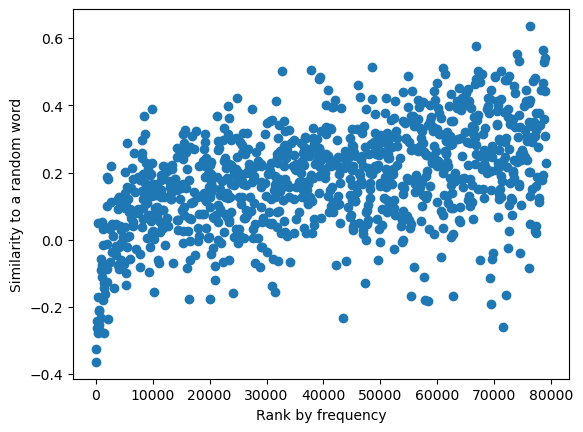

In [16]:
plt.scatter([p[0] for p in pairs], similarities)
plt.xlabel('Rank by frequency')
plt.ylabel('Similarity to a random word')
plt.show()

Checking most similar words for a rare word:

In [35]:
closest_words = []
for word, similarity in wv.most_similar('пітон', topn=5000):
    closest_words.append((word, similarity, wv.key_to_index[word])) 

for word, similarity, count in closest_words[:20]:
    print(word.ljust(10) + "\t" + "%.2f" % similarity, count)

антарыйскі	0.57 77507
шчытаморднік	0.56 70015
сенбернар 	0.54 71040
загнет    	0.54 73051
дыскаваць 	0.54 74487
шпігаваць 	0.53 52987
кляйнод   	0.53 62709
патагеннасць	0.53 65417
слівавы   	0.52 64696
затка     	0.52 76194
эканамістка	0.52 45105
гаўкнуць  	0.52 50454
расадзіна 	0.52 62246
вымуштраваць	0.52 71553
ліяна     	0.51 20911
малаба    	0.51 71896
гелікаптэр	0.51 77784
электрасілкаванне	0.51 30201
шаснаццацігоддзе	0.51 75587
сабаліны  	0.51 52885


It seems rare words are very close to other rare words.

In [30]:
wv.get_vector('пітон')

array([-0.315871, -0.826703,  0.104828, -0.129483, -0.248663, -0.458488,
       -0.860052, -0.221219,  0.446241,  0.653784, -0.021098,  0.473223,
       -0.276468,  0.065283,  0.008801,  0.059039,  0.37346 , -0.603582,
        0.709154, -0.423115,  1.570362,  0.306711,  0.547122, -0.305483,
       -0.063666,  0.194956, -0.336707,  0.137478,  1.057985,  0.550654,
        0.336613,  0.083958,  0.957045,  0.697968, -0.154006,  0.071094,
        0.294406,  0.618576,  0.74781 ,  0.556758,  0.105335, -0.165771,
       -0.612224, -0.479771, -0.618943, -0.577835, -0.766836, -0.509069,
        0.238068, -0.193322,  0.342027, -0.629672,  0.688413,  0.583811,
        0.752163, -0.28838 , -1.102798,  0.345102, -0.367965, -0.14504 ,
       -0.404096,  0.093468, -0.212583,  0.136299, -0.160533,  0.44829 ,
       -0.360188, -0.002455, -0.541351, -0.093861,  0.384396, -0.148804,
        0.00459 ,  0.812556, -0.398506, -0.907101, -0.175657,  0.016283,
        0.335295,  1.106481,  0.072736,  1.161137, 

In [29]:
np.mean(np.abs(wv.get_vector('пітон')))

0.38884127

In [28]:
np.mean(np.abs(wv.get_vector('беларусь')))

0.44033325

In [31]:
coord_abs_values = [np.mean(np.abs(wv.get_vector(word))) for word in wv.index_to_key]

Text(0, 0.5, 'Mean absolute coordinate value of embedding')

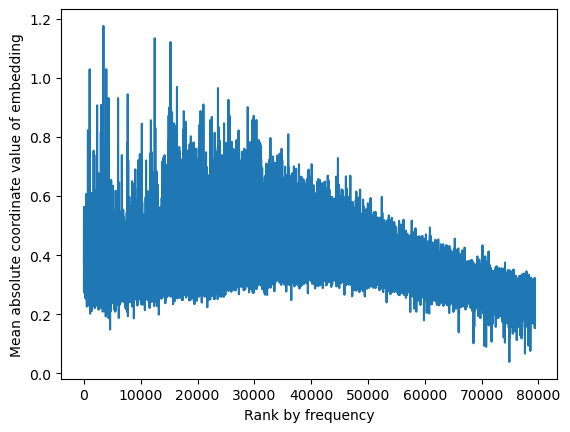

In [32]:
plt.plot(coord_abs_values)
plt.xlabel('Rank by frequency')
plt.ylabel('Mean absolute coordinate value of embedding')

Seems GloVe has less issues with rare words having low absolute values, however also suffers from the problem of rare words being close to other rare words.